#Directory, Libraries and Data

In [ ]:
#Change the directory
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [ ]:
#Import libraries
import numpy as np
import pandas as pd
from prophet import Prophet

In [ ]:
#Data
df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [ ]:
#Looking into what kind of variables we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


In [ ]:
#Summary statistics
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


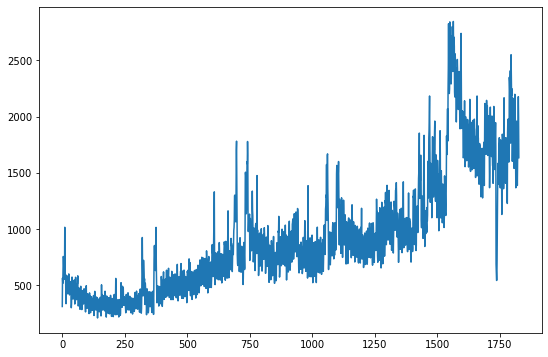

In [ ]:
#Plotting
df.Udemy.plot(figsize = (9,6))

#Data Preparation

In [ ]:
#Date variable: %m/%d/%Y -> %Y-%m-%d
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [ ]:
#Change variable: Date -> ds, time-series (Udemy) -> y
df = df.rename(columns = {'Date': 'ds',
                          'Udemy': 'y'})
df.head(1)

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0


#holidays

In [ ]:
#Easter
easter_dates = df[df.Easter ==1 ].ds
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [ ]:
#Black Friday
bf_dates = pd.to_datetime(df[df['Black Friday'] == 1].ds)
bf = pd.DataFrame({'holiday': 'black_friday',
                   'ds': bf_dates,
                   'lower_window': -7,
                   'upper_window': 5})

In [ ]:
#combine the holidays
holidays = pd.concat([easter, bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [ ]:
#Remove holidays from the main df
df = df.drop(columns = ["Easter", "Black Friday"])
df.head(0)

,ds,y,Christmas


#Prophet Model

In [ ]:
#Training and Test Split
test_days = 31
training = df.iloc[:-test_days, : ]
test = df.iloc[-test_days:, : ]
print(test.head(1))
print(training.tail(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1795 2020-11-30  2551          0


In [ ]:
#Prophet Model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale= 0.05)
m.add_regressor('Christmas', mode = 'multiplicative')
#m.add_regressor('XXXX')
m.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp35ruun11/sagow42k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35ruun11/kg07t_lc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6170', 'data', 'file=/tmp/tmp35ruun11/sagow42k.json', 'init=/tmp/tmp35ruun11/kg07t_lc.json', 'output', 'file=/tmp/tmp35ruun11/prophet_modelqkubcx70/prophet_model-20221122091446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Regressor coefficients
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.325782,-0.325782,-0.325782


#Forecasting

In [ ]:
#create future dataframe
future = m.make_future_dataframe(periods = test_days,
                                 freq = 'D')
future = pd.concat([future, df.iloc[:, 2:]],
                   axis = 1)
future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [ ]:
#forecasting
forecast = m.predict(future)
forecast.head()
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


In [ ]:
#Holiday assessment
holiday = 'black_friday'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]

,ds,black_friday
1785,2020-11-20,96.754441
1786,2020-11-21,88.306822
1787,2020-11-22,162.930394
1788,2020-11-23,235.557079
1789,2020-11-24,212.198298
1790,2020-11-25,182.895835
1791,2020-11-26,222.820740
1792,2020-11-27,455.972673
1793,2020-11-28,201.809595
1794,2020-11-29,226.606111


In [ ]:
#Retrieve the predictions
predictions = forecast.yhat[-test_days:]

In [ ]:
#Accuracy assessment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

184.37834758466064
235.98247544695192


#Visualization

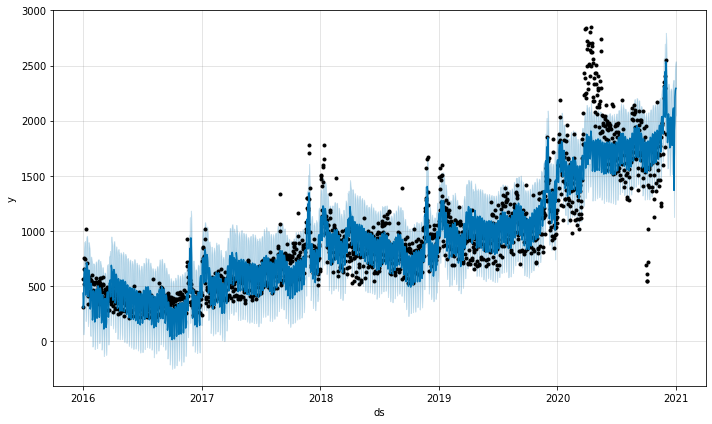

In [ ]:
#Visualize the forecast
m.plot(forecast);

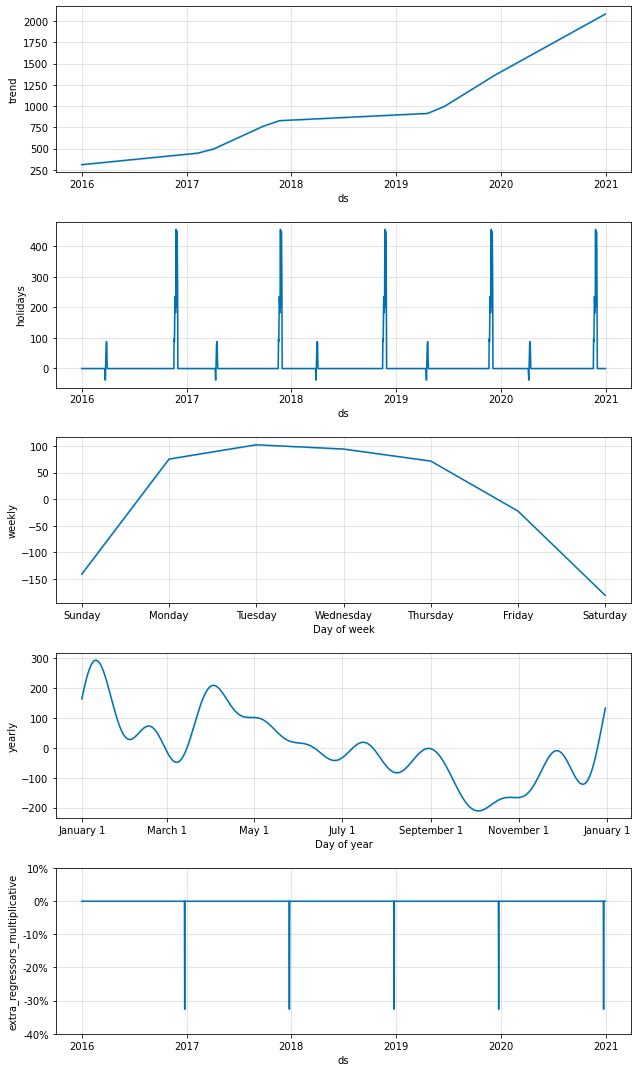

In [ ]:
#plot components -> Structural Time Series decomposition
m.plot_components(forecast);

#Cross-Validation

In [ ]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '1450 days',
                         parallel = 'processes')

In [ ]:
#Output of the CV
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1282.312306,1143.008545,1412.094727,1165,2019-12-25
1,2019-12-27,1223.730854,1084.553417,1357.746735,1111,2019-12-25
2,2019-12-28,1102.421650,975.570266,1228.360539,1038,2019-12-25
3,2019-12-29,1164.314368,1032.409868,1297.743240,971,2019-12-25
4,2019-12-30,1372.889606,1240.552730,1503.654640,1192,2019-12-25


In [ ]:
#Error assessment
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

398.8106048514321
516.9904970892578


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


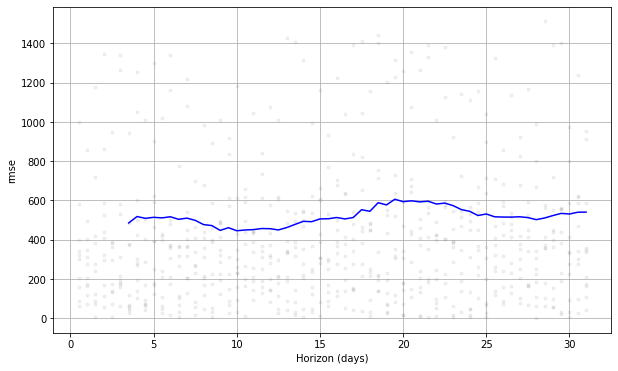

In [ ]:
#CV Visualization
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv,
                             metric = 'rmse');

#Parameter tuning

In [ ]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))              

54

In [ ]:
#Empty list to store results
rmse = []
#start the loop
for params in grid:
  #build the model
  m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale= params['changepoint_prior_scale'])
  m.add_regressor('Christmas', mode = 'multiplicative')
  m.fit(training)

  #Cross-Validation
  df_cv = cross_validation(m,
                           horizon = '31 days',
                           initial = '1450 days',
                           parallel = 'processes')

  #Measure and store results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

In [ ]:
#Get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,513.559746
1,0.01,5,additive,10,515.217856
2,0.01,5,additive,20,511.048738
3,0.01,5,multiplicative,5,531.021060
4,0.01,5,multiplicative,10,530.129718
5,0.01,5,multiplicative,20,530.675109
6,0.01,10,additive,5,512.222367
7,0.01,10,additive,10,513.155978
8,0.01,10,additive,20,510.641888
9,0.01,10,multiplicative,5,531.625249
